In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics

import matplotlib.pyplot as plt
import altair as alt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [IFT]')
    plt.legend()
    plt.grid(True)
    
def plot_ift(x, y):
    plt.scatter(train_features['Water_content'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Water_content')
    plt.ylabel('IFT')
    plt.legend()


# Case Study: Modeling IFT and Volume Expansion for Gas Injection in Heavy Oil Reservoirs

### OUTLINE

1. Problem Statement

2. Methodology

4. Results

4. Conclusions





### Problem Statement

- Lab experiments cost time and materials. Often we conduct many experiments to investigate how one or more variables, e.g. Type of Gas, Water Content, etc. effecting a target variable, IFT, Volume Ratio. However, the number of experiments needed to reveal this relationship is hard to capture.

- If we find a way to model the properties that we want to measure using data from experiments, then we could reduce the number of experiments required.

### Methodology 
- Determine the set of variables that are expected to affect the target variable
- Generate the data from limited set of experiments.
- Split the data into training and test set.
- Train a model using the training set and use model to predict the results for unseen data.
- Measure the performance of the model in terms of accuracy or any other type of pre-determined metrics.
- Continue conducting more experiments and repeat the process until getting the desired accuracy.


### Case Study: Prediction of IFT and Volume Ratio

- Target variables: Prediction IFT and Volume ratio for Gas injection in Heavy Oil Reservoir
- Covariates : 
 > 1. Type of Gas [Co2, CH4]
 > 2. Water Content in the emulsion [0-1]
 > 3. Time elapsed since starting the experiments
 > 4. Emulsion Viscosity

- Models : We will be testing three models:
> 1- Linear Regression Model : Assumes a linear relationship between the covariates and the target variable
> 2- Gradient Boosting Model : Creates ensemble of decision trees trained sequentially, each is optimized to reduce the error of the previous one
> 3- Artificial neural network ANN


In [2]:
ift_data = pd.read_excel('data/ift_data.xlsx')

In [3]:
# let's explore the data
ift_data.head()

,Gas,Water_content,viscosity,time_minutes,volume_ratio,IFT
0,CH4,0.0,27000.0,0.000050,1.000000,25.08
1,CH4,0.0,27000.0,14.998333,1.002618,25.12
2,CH4,0.0,27000.0,30.000000,1.005236,25.16
3,CH4,0.0,27000.0,45.000000,1.006108,25.17
4,CH4,0.0,27000.0,60.000000,1.007853,25.21


In [4]:
# quick glmipse into the number of rows
ift_data.info

<bound method DataFrame.info of      Gas  Water_content    viscosity  time_minutes  volume_ratio    IFT
0    CH4            0.0   27000.0000      0.000050      1.000000  25.08
1    CH4            0.0   27000.0000     14.998333      1.002618  25.12
2    CH4            0.0   27000.0000     30.000000      1.005236  25.16
3    CH4            0.0   27000.0000     45.000000      1.006108  25.17
4    CH4            0.0   27000.0000     60.000000      1.007853  25.21
..   ...            ...          ...           ...           ...    ...
556  CO2            0.7  236837.0833    150.000000      0.978155  19.93
557  CO2            0.7  236837.0833    165.000000      0.979369  19.95
558  CO2            0.7  236837.0833    180.000000      0.974515  19.87
559  CO2            0.7  236837.0833    195.000000      0.976942  19.92
560  CO2            0.7  236837.0833    210.000000      0.973301  19.86

[561 rows x 6 columns]>

In [5]:
alt.Chart(ift_data, title = 'Change in IFT with water content over time for CH4 and CO2').mark_circle(size=60).encode(
    alt.X('time_minutes:Q', title = 'Time'),
    alt.Y('IFT:Q'),
    alt.Color('Gas:N'),
).interactive()

alt.Chart(...)

In [6]:
alt.Chart(ift_data, title = 'Change in IFT with water content over time for CH4 and CO2').mark_circle(size=60).encode(
    alt.X('Water_content:Q', title = 'Water Content'),
    alt.Y('IFT:Q'),
    alt.Color('Gas:N'),
).interactive()

alt.Chart(...)

In [7]:
x= ift_data.iloc[:,:4] # get x
x

,Gas,Water_content,viscosity,time_minutes
0,CH4,0.0,27000.0000,0.000050
1,CH4,0.0,27000.0000,14.998333
2,CH4,0.0,27000.0000,30.000000
3,CH4,0.0,27000.0000,45.000000
4,CH4,0.0,27000.0000,60.000000
...,...,...,...,...
556,CO2,0.7,236837.0833,150.000000
557,CO2,0.7,236837.0833,165.000000
558,CO2,0.7,236837.0833,180.000000
559,CO2,0.7,236837.0833,195.000000


In [8]:
y = ift_data.iloc[:,5] # get y
y

0      25.08
1      25.12
2      25.16
3      25.17
4      25.21
       ...  
556    19.93
557    19.95
558    19.87
559    19.92
560    19.86
Name: IFT, Length: 561, dtype: float64

In [101]:
# splitting the data into train and test model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)
# since we have numeric and categorical features we will create a column transformer to transform them seperately
X_train

,Gas,Water_content,viscosity,time_minutes
204,CH4,0.33,61030.55556,630.0
558,CO2,0.70,236837.08330,180.0
514,CO2,0.10,35930.00000,915.0
252,CH4,0.45,74375.55556,555.0
164,CH4,0.20,45845.00000,660.0
...,...,...,...,...
98,CH4,0.10,35930.00000,615.0
322,CH4,0.50,86649.44444,780.0
382,CH4,0.70,236837.08330,735.0
365,CH4,0.70,236837.08330,480.0


### Modeling

In [4]:

def run_linear_model(X_train,train, viscosity = 'not_included'):
    
    if viscosity == 'not_included':
        numeric_features = ['Water_content', 'time_minutes',] 
    else:
         numeric_features = ['Water_content', 'time_minutes','viscosity']  
        
        

    # first transformer for the numeric features
        
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    # now a taransformer for the categorical features
    categorical_features = ['Gas']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    # creating a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    ridge_model = Ridge()
    # include the preprocessor and the model in one pipeline.
    # Now we have a full prediction pipeline.
    reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('Regressor', ridge_model)])

    # finally we will pass the pipe line to gridsearchcv to find the optimum paramters for the model
    param_grid = {
        'Regressor__alpha':[0.1,0.25,0.4],
    }
    search = GridSearchCV(reg_pipeline,param_grid,cv = 5)

    # fitting the model
    search.fit(X_train, y_train)

    # printing the first parameter
    print(search.best_params_)
    print("model score: %.3f" % search.score(X_test, y_test))
    return search


In [6]:
# lm = run_linear_model(X_train,y_train,viscosity = 'included')

In [119]:
# let's look at he model paramters
model_intercept = lm.best_estimator_['Regressor'].intercept_
model_intercept

22.641914511039513

In [120]:
model_slopes = lm.best_estimator_['Regressor'].coef_
model_slopes


array([-0.28426813, -0.15528172,  1.68815898, -1.68815898])

In [121]:
coeff_parameter = pd.DataFrame(lm.best_estimator_['Regressor'].coef_,columns=['Coefficient'])
coeff_parameter

,Coefficient
0,-0.284268
1,-0.155282
2,1.688159
3,-1.688159


In [14]:
# let's evaluate the model peroformance using MSE and MAE

In [122]:
y_pred = lm.predict(X_test)


In [123]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.0916569015462978
Mean Squared Error: 2.0925408260809752
Root Mean Squared Error: 1.4465617256380645


### Model Selection : Trying Gradient boosting

In [128]:

def run_gb_model(X_train,y_train, viscosity = 'not_included'):
    
    if viscosity == 'not_included':
        numeric_features = ['Water_content', 'time_minutes',] 
    else:
         numeric_features = ['Water_content', 'time_minutes','viscosity']    
    # first transformer for the numeric features    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    # now a taransformer for the categorical features
    categorical_features = ['Gas']
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    # creating a preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    gb_model = GradientBoostingRegressor()
    reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                          ('Regressor', gb_model)])
    param_grid = {
        'Regressor__learning_rate':[0.1,0.25,0.4],
    }
    search = GridSearchCV(reg_pipeline,param_grid,cv = 5)

    # fitting the model
    search.fit(X_train, y_train)

    # printing the first parameter
    print(search.best_params_)
    print("model score: %.3f" % search.score(X_test, y_test))
    return search

In [130]:
gb = run_gb_model(X_train,y_train, viscosity = 'not_included')

{'Regressor__learning_rate': 0.4}
model score: 0.995


In [131]:
print("model score: %.3f" % gb.score(X_test, y_test))


model score: 0.995


In [132]:
y_pred = gb.predict(X_test)

In [133]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 0.07874543098019307
Mean Squared Error: 0.021835685391972143
Root Mean Squared Error: 0.14776902717407372


In [134]:
# prediction for a new value

In [135]:
new_data = X_test.iloc[[0]]
new_data

,Gas,Water_content,viscosity,time_minutes
466,CO2,0.1,35930.0,195.0


In [136]:
gb.predict(new_data)

array([19.1559994])

In [137]:
# How predictions compared with the actual results

X_test.loc[:,'true_ift'] = y_test[:]
X_test.loc[:,'predicted_ift'] = y_pred[:]
X_test

,Gas,Water_content,viscosity,time_minutes,true_ift,predicted_ift
466,CO2,0.10,35930.00000,195.0,19.12,19.155999
157,CH4,0.20,45845.00000,555.0,24.38,24.409911
452,CO2,0.00,35930.00000,930.0,23.80,23.903846
449,CO2,0.00,35930.00000,885.0,23.81,23.763949
467,CO2,0.10,35930.00000,210.0,19.09,19.120444
...,...,...,...,...,...,...
508,CO2,0.10,35930.00000,825.0,18.91,18.897314
374,CH4,0.70,236837.08330,615.0,25.08,25.193992
181,CH4,0.20,45845.00000,915.0,24.54,24.562454
485,CO2,0.10,35930.00000,480.0,18.91,18.949683


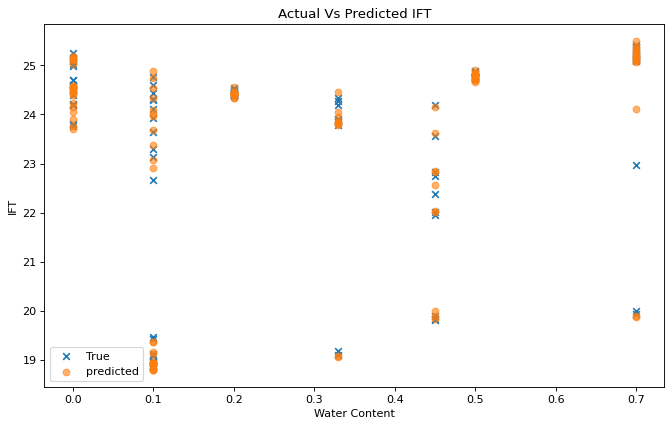

In [140]:
plt.figure(figsize=(10, 6), dpi=80)
plt.scatter(X_test['Water_content'],X_test['true_ift'], marker = 'x', label="True" )
plt.scatter(X_test['Water_content'],X_test['predicted_ift'],marker = 'o', alpha = 0.6, label="predicted")
plt.xlabel("Water Content")
plt.ylabel("IFT")
plt.legend(loc='lower left')
plt.title('Actual Vs Predicted IFT')
plt.show()

In [26]:
## saving thee model for future use : 

In [27]:
from joblib import dump, load


dump(search.best_estimator_, 'model.pkl')

['model.pkl']

In [141]:

model1 = load('model.pkl')

model1.predict(new_data)

array([19.1559994])

- The effect of emulsion viscosity: Re run the model with oil viscosity included.

### ANN

In [142]:
## Bulidng simple linear model with one feature: Water Content

In [143]:
ift_data = pd.read_excel('data/ift_data.xlsx')

In [144]:
len(ift_data)

561

In [145]:
X= ift_data[['Water_content']] # get x
y = ift_data.iloc[:,5] # get y

In [146]:
X.head()

,Water_content
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [147]:
y

0      25.08
1      25.12
2      25.16
3      25.17
4      25.21
       ...  
556    19.93
557    19.95
558    19.87
559    19.92
560    19.86
Name: IFT, Length: 561, dtype: float64

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)

train_features = X_train[['Water_content']]
test_features = X_test[['Water_content']]
normalizer = preprocessing.Normalization()

In [149]:
train_labels = y_train
test_labels = y_test
features = np.array(X_train)
f_normalizer = preprocessing.Normalization(input_shape=[1,])
f_normalizer.adapt(features)
linear_model = tf.keras.Sequential([
    f_normalizer,
    layers.Dense(units=1)
])
linear_model.summary()



Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [150]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')


In [151]:
%%time
history = linear_model.fit(
    train_features, train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 2.2 s, sys: 168 ms, total: 2.37 s
Wall time: 1.99 s


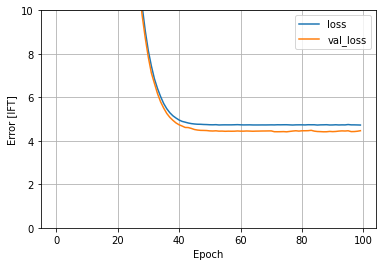

In [152]:
plot_loss(history)

In [153]:
test_results = {}

test_results['linear_model'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.306371212005615}

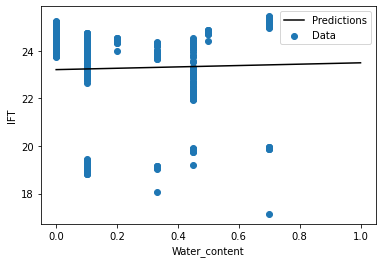

In [154]:
water_content = tf.linspace(0.0, 1, 251)
ift = linear_model.predict(water_content )
plot_ift(water_content,ift)



In [155]:
### Non-linear Model

In [156]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [157]:
dnn_horsepower_model = build_and_compile_model(f_normalizer)
dnn_horsepower_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [158]:
%%time
history = dnn_horsepower_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 2.68 s, sys: 447 ms, total: 3.13 s
Wall time: 2.22 s


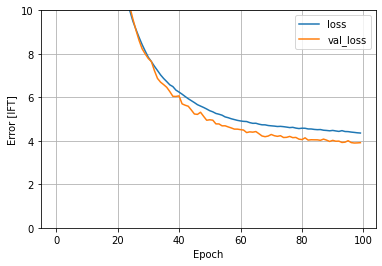

In [159]:
plot_loss(history)

In [160]:
test_results['non_linear'] =dnn_horsepower_model.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.306371212005615, 'non_linear': 3.9734530448913574}

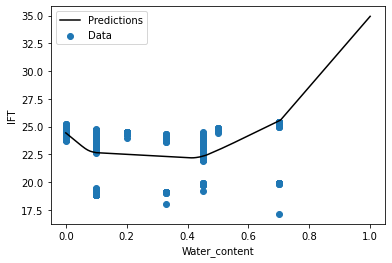

In [161]:
water_content = tf.linspace(0.0, 1, 251)
ift = dnn_horsepower_model.predict(water_content )
plot_ift(water_content, ift)

### Adding More Features:

In [163]:
ift_data = pd.read_excel('data/ift_data.xlsx')
X= ift_data[['Water_content','viscosity','time_minutes','Gas']] # get x
y = ift_data['IFT'] # get y

X

,Water_content,viscosity,time_minutes,Gas
0,0.0,27000.0000,0.000050,CH4
1,0.0,27000.0000,14.998333,CH4
2,0.0,27000.0000,30.000000,CH4
3,0.0,27000.0000,45.000000,CH4
4,0.0,27000.0000,60.000000,CH4
...,...,...,...,...
556,0.7,236837.0833,150.000000,CO2
557,0.7,236837.0833,165.000000,CO2
558,0.7,236837.0833,180.000000,CO2
559,0.7,236837.0833,195.000000,CO2


In [164]:
X = pd.get_dummies(X, prefix='', prefix_sep='')
X.head()

,Water_content,viscosity,time_minutes,CH4,CO2
0,0.0,27000.0,0.000050,1,0
1,0.0,27000.0,14.998333,1,0
2,0.0,27000.0,30.000000,1,0
3,0.0,27000.0,45.000000,1,0
4,0.0,27000.0,60.000000,1,0


In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=True)
train_features = X_train
test_features = X_test


In [167]:
normalizer = preprocessing.Normalization()
train_labels = y_train
test_labels = y_test
features = np.array(X_train)
ift_normalizer = preprocessing.Normalization(input_shape=[5,])
ift_normalizer.adapt(features)
ift_model = tf.keras.Sequential([
    ift_normalizer,
    layers.Dense(units=1)
])
ift_model.summary()



Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 6         
Total params: 17
Trainable params: 6
Non-trainable params: 11
_________________________________________________________________


In [168]:
all_features_model = build_and_compile_model(ift_normalizer)
all_features_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_32 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 65        
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [169]:
%%time
history = all_features_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.04 s, sys: 484 ms, total: 3.52 s
Wall time: 2.55 s


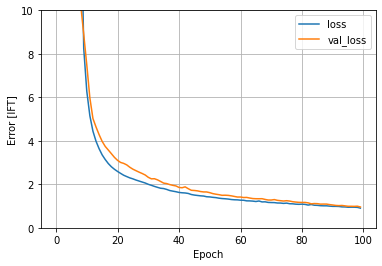

In [170]:
plot_loss(history)

In [171]:
test_results['all_features'] =all_features_model.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.306371212005615,
 'non_linear': 3.9734530448913574,
 'all_features': 0.9945210218429565}

In [57]:
### Deep Learning: The effect of adding more layers to the ANN

In [172]:
def build_and_compile_model_4(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [173]:
def build_and_compile_model_6(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [174]:
def build_and_compile_model_8(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])
    model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
    return model

In [175]:
### 4 layers

In [190]:
all_features_model_enhanced = build_and_compile_model_4(ift_normalizer)
all_features_model_enhanced.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_53 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_54 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_55 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_56 (Dense)             (None, 1)                 65        
Total params: 8,780
Trainable params: 8,769
Non-trainable params: 11
_________________________________________________________________


In [191]:
%%time
history = all_features_model_enhanced.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 4min 35s, sys: 59.7 s, total: 5min 34s
Wall time: 3min 30s


In [192]:
test_results['all_features_enhanced'] =all_features_model_enhanced.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.306371212005615,
 'non_linear': 3.9734530448913574,
 'all_features': 0.9945210218429565,
 'all_features_enhanced': 0.049696799367666245}

In [179]:
### 6 Layers: 
all_features_model_enhanced = build_and_compile_model_6(ift_normalizer)
all_features_model_enhanced.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_39 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_42 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 1)               

In [180]:
%%time
history = all_features_model_enhanced.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 5min 7s, sys: 1min 31s, total: 6min 38s
Wall time: 3min 29s


In [181]:
test_results['all_features_enhanced'] =all_features_model_enhanced.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.306371212005615,
 'non_linear': 3.9734530448913574,
 'all_features': 0.9945210218429565,
 'all_features_enhanced': 0.06530319154262543}

In [182]:
### 8 Layers: 
all_features_model_enhanced = build_and_compile_model_8(ift_normalizer)
all_features_model_enhanced.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 5)                 11        
_________________________________________________________________
dense_45 (Dense)             (None, 64)                384       
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_48 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_49 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_50 (Dense)             (None, 64)              

In [183]:
%%time
history = all_features_model_enhanced.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=10000)

CPU times: user 5min 52s, sys: 1min 52s, total: 7min 44s
Wall time: 3min 50s


In [184]:
test_results['all_features_enhanced'] =all_features_model_enhanced.evaluate(
    test_features,
    test_labels, verbose=0)
test_results

{'linear_model': 4.306371212005615,
 'non_linear': 3.9734530448913574,
 'all_features': 0.9945210218429565,
 'all_features_enhanced': 0.07023238390684128}

In [193]:
# Best Model : All features with 4 layers

In [189]:
pd.DataFrame(test_results.items(), columns = ['Model','MSE'])

,Model,MSE
0,linear_model,4.306371
1,non_linear,3.973453
2,all_features,0.994521
3,all_features_enhanced,0.070232
